In [1]:
from typing import Dict
import os
import random
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import femm
from scipy.stats import linregress
from numba import jit


In [2]:
three_points = {'equator': [1, 0],
          'inner_throat': [.833, -0.553],
          'outer_throat': [.530, -0.553]
}
above_equator_point = [0.836780043790687, 0.547539795401629]

In [3]:
femm.openfemm(1)
femm.opendocument('/home/brendan.posehn@gf.local/dev/gf/flagships/ext_psi_files/pi3/A_C362_D-343.ans')
x_point_diffs = 1000
profile_diffs = 0
[femm.mo_geta(x_point_diffs,profile_diffs), *femm.mo_getb(x_point_diffs,profile_diffs)]

wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


[0.006531529554953316, 0.001238545778457434, 0.001565398095519557]

In [3]:
def get_flux_at_points(ansfile: str, xs, ys):
    femm.openfemm(1)
    femm.opendocument(ansfile)
    fluxes = np.array([femm.mo_geta(x*1e3,y*1e3) for x, y in zip(xs, ys)])

    return fluxes

In [4]:
# coil config shold be 'A', not 'Coil_A'
def get_flux_at_coil_config_and_points(coil_config: Dict[str, float], xs, ys):
    femm.openfemm(1)
    fluxes = np.zeros_like(xs)
    for coil_name, coil_value in coil_config.items():
        if coil_name.startswith('Coil_'):
            coil_name = coil_name[-1]
        ansfile = f'{os.getenv("AURORA_REPOS")}/reconstruction/tools/table_tools/coil_current_clustering_tools/FEMM_plotting/pi3b_femm_1A/pi3b_asbuilt_Coil_{coil_name}_1A.ans'
        print(coil_name)
        femm.opendocument(ansfile)
        pre_scale_coil_fluxes = np.array([femm.mo_geta(x*1e3, y*1e3) for x, y in zip(xs, ys)])
        print(pre_scale_coil_fluxes)
        print(coil_value)
        fluxes += pre_scale_coil_fluxes * coil_value
    
    femm.closefemm()
    return fluxes

In [5]:
def get_flux_per_amp_at_points(xs, ys):
    coil_names = ['A', 'B', 'C', 'D', 'PFC_1', 'PFC_2']
    data = {}
    femm.openfemm()
    for coil_name in coil_names:
        ansfile = f'{os.getenv("AURORA_REPOS")}/reconstruction/tools/table_tools/coil_current_clustering_tools/FEMM_plotting/pi3b_femm_1A/pi3b_asbuilt_Coil_{coil_name}_1A.ans'
        print(coil_name)
        femm.opendocument(ansfile)
        data[coil_name] = np.array([femm.mo_geta(x*1e3, y*1e3) for x, y in zip(xs, ys)])
        data[f'{coil_name}_equator'] = femm.mo_geta(three_points['equator'][0]*1e3, three_points['equator'][1]*1e3)

    data['xs'] = xs
    data['ys'] = ys

    femm.closefemm()
    return data

In [ ]:
# coil_config = {'A': 47, 'C': 394, 'Coil_D': 239, 'PFC_1': -165, 'PFC_2': -84}
# print(get_flux_at_coil_config_and_points(coil_config, [1, .833], [0, -.553]))
# femm.closefemm()

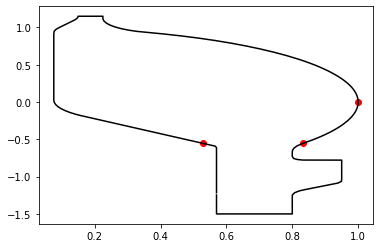

In [6]:
from flagships.post_processing.ParseFlagshipsFile import FlagshipsParser
from flagships.post_processing.EquilibriumPlotting import PlotBoundary
f = FlagshipsParser('', 'A_46-B_0-C_396-D_-61-PFC_1_-161-PFC_2_-83_s0.010_dc-0.018_a0.5_b0.5_c0.30_y5.0_i0.40_b0.20_pa2_pb02.hdf5')

PlotBoundary(f)
for pt in three_points.values():
    plt.scatter(pt[0], pt[1], c='r')

In [7]:
boundary_points = f.GetEdgePoints()
contour_threshold = -0.610
z_mask = np.where(boundary_points[:, 1] > contour_threshold)[0]
contour_points = boundary_points[z_mask]

num_additional_points = 10
additional_point_r_values = np.linspace(contour_points[0, 0], contour_points[-1, 0], num_additional_points+2)[1:-1]
additional_points = np.ones((num_additional_points, 2))
additional_points[:, 0] = additional_point_r_values
additional_points[:, 1] = np.ones_like(additional_point_r_values)*contour_points[0, 1]

contour_points = np.vstack((contour_points, additional_points))


In [8]:
boundary_points = f.GetEdgePoints()
contour_threshold = -0.610
z_mask = np.where(boundary_points[:, 1] > contour_threshold)[0]
z_mask_points = boundary_points[z_mask]

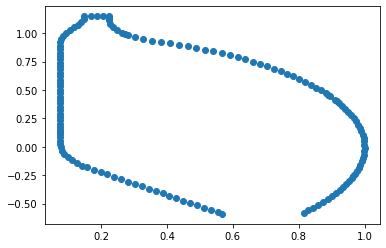

In [9]:
plt.scatter(z_mask_points[:, 0], z_mask_points[:, 1])

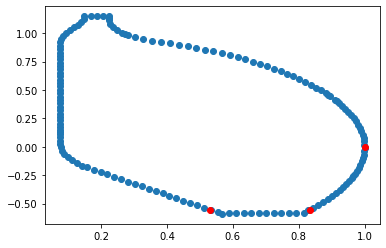

In [10]:
plt.scatter(contour_points[:, 0], contour_points[:, 1])
for pt in three_points.values():
    plt.scatter(pt[0], pt[1], c='r')

In [22]:
boundary_3pt_indices = []
for three_pt_x, three_pt_y in zip(three_pt_xs, three_pt_ys):
    boundary_3pt_indices.append(np.argmin(abs(contour_points[:, 0] - three_pt_x) + abs(contour_points[:, 1] - three_pt_y)))
    

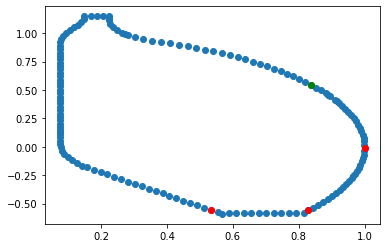

In [68]:
plt.scatter(contour_points[:, 0], contour_points[:, 1])
for idx in boundary_3pt_indices:
    plt.scatter(contour_points[idx, 0],  contour_points[idx, 1], c='r')
higher_point_idx = 44
plt.scatter(contour_points[higher_point_idx, 0],  contour_points[higher_point_idx, 1], c='g')

In [13]:
contour_points[higher_point_idx, 0],  contour_points[higher_point_idx, 1]

(0.836780043790687, 0.547539795401629)

In [45]:
boundary_3pt_indices = closest_idxs

In [85]:
def get_flux_along_contour_from_data(coil_config, flux_per_amp_data):
    flux_along_contour = np.zeros_like(flux_per_amp_data['xs'])
    for coil_name, coil_value in coil_config.items():
        flux_along_contour += flux_per_amp_data[coil_name] * coil_value
    return flux_along_contour

In [86]:
def get_flux_at_equator(coil_config, flux_per_amp_data):
    flux_at_equator = 0
    for coil_name, coil_value in coil_config.items():
        flux_at_equator += flux_per_amp_data[f'{coil_name}_equator'] * coil_value
    return flux_at_equator

In [ ]:
coil_config = {'A': 47, 'C': 394, 'D': 239, 'PFC_1': -165, 'PFC_2': -84}
fluxes = get_flux_at_coil_config_and_points(coil_config, contour_points[:, 0], contour_points[:, 1])

In [ ]:
coil_config = {'A': 47, 'C': 394, 'D': 239, 'PFC_1': -165, 'PFC_2': -84}

fluxes_ = get_flux_along_contour_from_data(coil_config, flux_per_amp_at_boundary)

perhaps do something faster than opening femm each time, could save for each point instead of opening and reopening each time 

do random coil iterations until find poor fit

In [18]:
from GF_data_tools.fetch_data import get_shot_scalars

NUM_SHOT_CONFIGS = 0
COIL_NAMES = ['A', 'C', 'D', 'PFC_1', 'PFC_2']

def get_random_shot_coil_config():
    while True:
        try:
            shot_number = int(np.random.uniform(18000, 22500))
            shot_scalars = get_shot_scalars('pi3b', 'default', shot_number)
            if 'A' in shot_scalars.keys():
                break
        except:
            continue

    shot_coil_values = {}
    for coil_name in COIL_NAMES:
        if coil_name == 'PFC_1':
            query_coil_name = 'E'
        elif coil_name == 'PFC_2':
            query_coil_name = 'F'
        else:
            query_coil_name = coil_name
        
        # print(shot_scalars.keys(), query_coil_name)
        shot_coil_values[coil_name] = shot_scalars[query_coil_name]['coil_current_at_form']['value']
    # print(shot_coil_values)
    return shot_coil_values

def get_random_coil_config():
    coil_multiples = np.random.rand((4)) - .5
    pfc_ratio = np.random.uniform(low=0.7, high=1.3)
    coil_config = {coil_name: 500*coil_multiple for coil_name, coil_multiple in zip(COIL_NAMES[:-1], coil_multiples)}
    coil_config['PFC_2'] = pfc_ratio*coil_config['PFC_1']

    return coil_config

def get_flux_differences_from_flux_per_amp_at_points(flux_per_amp_at_points, flux_per_amp_at_3_points):
    num_random_configs = 10000
    three_pt_diffs = []
    profile_diffs = []
    configs = []

    for i_config in range(num_random_configs + NUM_SHOT_CONFIGS):
        if i_config < num_random_configs:
            coil_config_1 = get_random_coil_config()
            coil_config_2 = get_random_coil_config()
        else:
            print('eee')
            coil_config_1 = get_random_shot_coil_config()
            coil_config_1 = get_random_shot_coil_config()
        configs.append([coil_config_1, coil_config_2])

        flux_along_contour_1 = get_flux_along_contour_from_data(coil_config_1, flux_per_amp_at_points)
        flux_along_contour_2 = get_flux_along_contour_from_data(coil_config_2, flux_per_amp_at_points)

        three_pt_fluxes_1 = get_flux_along_contour_from_data(coil_config_1, flux_per_amp_at_3_points)
        three_pt_fluxes_2 = get_flux_along_contour_from_data(coil_config_2, flux_per_amp_at_3_points)

        equator_flux_ratio_1_to_2 = get_flux_at_equator(coil_config_1, flux_per_amp_at_points) / get_flux_at_equator(coil_config_2, flux_per_amp_at_points)

        flux_along_contour_2 *= equator_flux_ratio_1_to_2
        three_pt_fluxes_2 *= equator_flux_ratio_1_to_2

        # three_pt_diff = abs((three_pt_fluxes_1 - three_pt_fluxes_2) / np.maximum(abs(three_pt_fluxes_1), abs(three_pt_fluxes_2))).mean()
        # profile_diff = abs((flux_along_contour_1 - flux_along_contour_2) / np.maximum(abs(flux_along_contour_1), abs(flux_along_contour_2))).mean()

        # three_pt_diff = np.linalg.norm((three_pt_fluxes_1 - three_pt_fluxes_2) / np.maximum(abs(three_pt_fluxes_1), abs(three_pt_fluxes_2)))
        # profile_diff = np.linalg.norm((flux_along_contour_1 - flux_along_contour_2) / np.maximum(abs(flux_along_contour_1), abs(flux_along_contour_2)))

        three_pt_diff = abs(three_pt_fluxes_1 - three_pt_fluxes_2).mean()
        profile_diff = abs(flux_along_contour_1[:-10] - flux_along_contour_2[:-10]).mean()

        three_pt_diffs.append(three_pt_diff)
        profile_diffs.append(profile_diff)

    return three_pt_diffs, profile_diffs


In [18]:
def try_random_point_selections(flux_per_amp_at_points, num_points, num_combinations):
    num_coil_configs = 5000
    coil_configs = []
    for _ in range(num_coil_configs):
        coil_config_1 = get_random_coil_config()
        coil_config_2 = get_random_coil_config()
        coil_configs.append((coil_config_1, coil_config_2))

    mean_residuals = np.empty((num_combinations))
    correlations = np.empty((num_combinations))
    points = np.empty((num_combinations, num_points, 2))
    for i_combination in range(num_combinations):
        pt_indices = random.sample(range(len(flux_per_amp_at_points['xs'])), num_points)
        for i_pt_index, pt_index in enumerate(pt_indices):
            points[i_combination, i_pt_index] = [flux_per_amp_at_points['xs'][pt_index], flux_per_amp_at_points['ys'][pt_index]]

        x_point_diffs = np.empty((num_coil_configs))
        profile_diffs = np.empty((num_coil_configs))
        for i_coil_config, (coil_config_1, coil_config_2) in enumerate(coil_configs):
            flux_along_contour_1 = get_flux_along_contour_from_data(coil_config_1, flux_per_amp_at_points)
            flux_along_contour_2 = get_flux_along_contour_from_data(coil_config_2, flux_per_amp_at_points)

            equator_flux_ratio_1_to_2 = get_flux_at_equator(coil_config_1, flux_per_amp_at_points) / get_flux_at_equator(coil_config_2, flux_per_amp_at_points)

            flux_along_contour_2 *= equator_flux_ratio_1_to_2

            x_point_diff = abs(flux_along_contour_1[pt_indices] - flux_along_contour_2[pt_indices]).mean()
            profile_diff = abs(flux_along_contour_1 - flux_along_contour_2).mean()

            x_point_diffs[i_coil_config] = x_point_diff
            profile_diffs[i_coil_config] = profile_diff

        fit_result = linregress(x_point_diffs, profile_diffs)
        fit_vals = (x_point_diffs*fit_result.slope) + fit_result.intercept
        mean_residuals[i_combination] = abs(fit_vals - profile_diffs).mean()
        correlations[i_combination] = fit_result.rvalue

    return mean_residuals, correlations, points

In [14]:
def get_random_coil_config_pairs(num_coil_configs):
    coil_configs_1 = np.empty((num_coil_configs, len(COIL_NAMES)))
    coil_configs_2 = np.empty((num_coil_configs, len(COIL_NAMES)))
    for i_coil_config in range(num_coil_configs):
        cfg_1, cfg_2 = get_random_coil_config(), get_random_coil_config()
        coil_configs_1[i_coil_config] = [cfg_1[coil_name] for coil_name in COIL_NAMES]
        coil_configs_2[i_coil_config] = [cfg_2[coil_name] for coil_name in COIL_NAMES]

    return coil_configs_1, coil_configs_2

def numbad_try_random_point_selections(flux_per_amp_at_points, num_points, num_combinations, num_coil_configs=20000):
    flux_per_amp_at_points_arr = np.vstack(tuple(flux_per_amp_at_points[coil_name] for coil_name in COIL_NAMES)).T
    flux_per_amp_at_equator_arr = np.array([flux_per_amp_at_points[f'{coil_name}_equator'] for coil_name in COIL_NAMES])

    coil_configs_1, coil_configs_2 = get_random_coil_config_pairs(num_coil_configs)

    random_point_indices = np.random.rand(num_combinations, num_points)*flux_per_amp_at_points_arr.shape[0]
    random_point_indices = random_point_indices.astype(int)

    #is num_combinaions x num_coil_configs
    residuals = _numbad_try_random_point_selections(flux_per_amp_at_points_arr, flux_per_amp_at_equator_arr,
                                                        coil_configs_1, coil_configs_2, num_points, num_combinations,
                                                        random_point_indices)
    points = np.empty((num_combinations, num_points, 2))
    for i_combination in range(random_point_indices.shape[0]):
        for i_point in range(random_point_indices.shape[1]):
            pt_index = random_point_indices[i_combination, i_point]
            points[i_combination, i_point] = [flux_per_amp_at_points['xs'][pt_index], flux_per_amp_at_points['ys'][pt_index]]

    return residuals, points

@jit(nopython=True)
def _numbad_get_flux_at_coil_config(flux_per_amp_arr, coil_config_arr):
    return flux_per_amp_arr @ coil_config_arr

def num_coil_config_sensitivity(flux_per_amp_at_points, num_points, num_coil_configs_to_try, num_combinations):
    flux_per_amp_at_points_arr = np.vstack(tuple(flux_per_amp_at_points[coil_name] for coil_name in COIL_NAMES)).T
    flux_per_amp_at_equator_arr = np.array([flux_per_amp_at_points[f'{coil_name}_equator'] for coil_name in COIL_NAMES])

    random_point_indices = np.random.rand(num_combinations, num_points)*flux_per_amp_at_points_arr.shape[0]
    random_point_indices = random_point_indices.astype(int)

    coil_configs_1, coil_configs_2 = get_random_coil_config_pairs(num_coil_configs_to_try)

    residuals = _numbad_try_random_point_selections(flux_per_amp_at_points_arr, flux_per_amp_at_equator_arr,
                                                        coil_configs_1, coil_configs_2, num_points, num_combinations,
                                                        random_point_indices)
    return residuals

def get_defined_pt_config_sensitivity(flux_per_amp_at_points, num_coil_configs_to_try, point_indices):
    flux_per_amp_at_points_arr = np.vstack(tuple(flux_per_amp_at_points[coil_name] for coil_name in COIL_NAMES)).T
    flux_per_amp_at_equator_arr = np.array([flux_per_amp_at_points[f'{coil_name}_equator'] for coil_name in COIL_NAMES])

    random_point_indices = np.array([point_indices])

    coil_configs_1, coil_configs_2 = get_random_coil_config_pairs(num_coil_configs_to_try)

    residuals = _numbad_try_random_point_selections(flux_per_amp_at_points_arr, flux_per_amp_at_equator_arr,
                                                        coil_configs_1, coil_configs_2, len(point_indices), 1,
                                                        random_point_indices)
    
    points = np.empty((1, len(point_indices), 2))
    for i_combination in range(random_point_indices.shape[0]):
        for i_point in range(random_point_indices.shape[1]):
            pt_index = random_point_indices[i_combination, i_point]
            points[i_combination, i_point] = [flux_per_amp_at_points['xs'][pt_index], flux_per_amp_at_points['ys'][pt_index]]

    return residuals, points

@jit(nopython=True)
def _numbad_try_random_point_selections(flux_per_amp_at_points_arr, flux_per_amp_at_equator_arr, coil_configs_1, coil_configs_2, num_points, num_combinations, random_point_indices):
    num_coil_configs = coil_configs_1.shape[0]

    residuals = np.empty((num_combinations, num_coil_configs))
    for i_combination in range(num_combinations):
        pt_indices = random_point_indices[i_combination]

        x_point_diffs = np.empty((num_coil_configs))
        profile_diffs = np.empty((num_coil_configs))
        for i_coil_config in range(num_coil_configs):
            coil_config_1 = coil_configs_1[i_coil_config]
            coil_config_2 = coil_configs_2[i_coil_config]

            flux_at_points_1 = _numbad_get_flux_at_coil_config(flux_per_amp_at_points_arr, coil_config_1)
            flux_at_points_2 = _numbad_get_flux_at_coil_config(flux_per_amp_at_points_arr, coil_config_2)

            equator_flux_ratio_1_to_2 = _numbad_get_flux_at_coil_config(coil_config_1, flux_per_amp_at_equator_arr) / \
                                        _numbad_get_flux_at_coil_config(coil_config_2, flux_per_amp_at_equator_arr)

            flux_at_points_2 *= equator_flux_ratio_1_to_2

            x_point_diff = np.abs(flux_at_points_1[pt_indices] - flux_at_points_2[pt_indices]).mean()
            # profile_diff = np.abs(flux_at_points_1 - flux_at_points_2).mean()
            profile_diff = np.abs(flux_at_points_1[:-10] - flux_at_points_2[:-10]).mean() # cuz added 10 points across gun

            x_point_diffs[i_coil_config] = x_point_diff
            profile_diffs[i_coil_config] = profile_diff

        A = np.ones((num_coil_configs, 2))
        for i in range(num_coil_configs):
            A[i, 0] = x_point_diffs[i]

        res = np.linalg.lstsq(A, profile_diffs)[0]
        m = res[0]
        b = res[1]
        fit_vals = (x_point_diffs*m) + b

        residuals[i_combination] = np.abs(fit_vals - profile_diffs)

    return residuals


In [90]:
def plot_flux_diffs(flux_per_amp_at_points):
    three_pt_diffs, profile_diffs = get_flux_differences_from_flux_per_amp_at_points(flux_per_amp_at_points, flux_per_amp_3pt)
    plt.figure(figsize=(12, 8))
    plt.scatter(three_pt_diffs, profile_diffs, alpha=.2, label='Random Pair')
    # plt.scatter(three_pt_diffs[NUM_SHOT_CONFIGS:], profile_diffs[NUM_SHOT_CONFIGS:], alpha=.2, label='Random Pair')
    # plt.scatter(three_pt_diffs[-NUM_SHOT_CONFIGS:], profile_diffs[-NUM_SHOT_CONFIGS:], label='Shot Pair')
    max_val = plt.gca().get_xlim()[1]
    plt.plot([0, max_val], [0, max_val], c='k', linestyle='--', label='slope=1')
    plt.xlabel('3pt Diff (Wb)')
    plt.ylabel('Profile Diff (Wb)')

    from scipy.stats import linregress
    result = linregress(three_pt_diffs, profile_diffs)
    plt.annotate(f'R={result.rvalue}', (0.5, .1), size=16)
    plt.plot([0, max_val], [0, max_val*result.slope], c='c', linestyle='--', label='fit slope')

    fit_vals = (np.array(three_pt_diffs)*result.slope) + result.intercept
    mean_residual = abs(fit_vals - profile_diffs).mean()
    
    print(f'{result.slope=}, {result.stderr=}, {mean_residual=}, {result.rvalue=}')

In [14]:
from shapely import Polygon, Point

In [15]:
contour_polygon = Polygon(contour_points)

In [16]:
num_internal_points = 500
internal_xs = []
internal_ys = []
while len(internal_xs) < num_internal_points:
    x_point_diffs = np.random.uniform(.07, 1)
    profile_diffs = np.random.uniform(-.5, 1)
    if contour_polygon.contains(Point(x_point_diffs, profile_diffs)):
        internal_xs.append(x_point_diffs)
        internal_ys.append(profile_diffs)

In [17]:
flux_per_amp_internal = get_flux_per_amp_at_points(internal_xs, internal_ys)

A


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


B


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


C


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


D


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


PFC_1


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


PFC_2


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


In [32]:
flux_per_amp_boundary = get_flux_per_amp_at_points(contour_points[:, 0], contour_points[:, 1])

A


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


B


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


C


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


D


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


PFC_1


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


PFC_2


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


In [12]:
three_pt_xs = [pt[0] for pt in three_points.values()]
three_pt_ys = [pt[1] for pt in three_points.values()]

flux_per_amp_3pt = get_flux_per_amp_at_points(three_pt_xs, three_pt_ys)

A


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


B


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


C


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


D


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


PFC_1


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


PFC_2


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


In [19]:
flux_per_amp_3pt

{'A': array([5.67492121e-05, 1.01440770e-04, 4.91624010e-05]),
 'A_equator': 5.674921213420124e-05,
 'B': array([2.58749354e-05, 3.82529670e-05, 1.77042760e-05]),
 'B_equator': 2.587493536172493e-05,
 'C': array([2.72113767e-05, 4.82426495e-05, 2.56830811e-05]),
 'C_equator': 2.721137670566567e-05,
 'D': array([9.76169848e-06, 2.11307285e-05, 1.41560421e-05]),
 'D_equator': 9.76169847954186e-06,
 'PFC_1': array([1.24347051e-04, 1.71670928e-04, 5.70198648e-05]),
 'PFC_1_equator': 0.0001243470510080046,
 'PFC_2': array([1.30142942e-04, 4.48563526e-05, 2.09787549e-05]),
 'PFC_2_equator': 0.0001301429421405099,
 'xs': [1, 0.833, 0.53],
 'ys': [0, -0.553, -0.553]}

In [16]:
flux_per_amp_3pt_plus = get_flux_per_amp_at_points(three_pt_xs + [above_equator_point[0]], three_pt_ys + [above_equator_point[1]])

A


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


B


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


C


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


D


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


PFC_1


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


PFC_2


wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.
wine: Read access denied for device L"\\??\\Z:\\", FS volume label and serial are not available.


In [18]:
pickle.dump(flux_per_amp_3pt_plus, open('flux_per_amp_3pt_plus.pickle', 'wb'))

In [ ]:
fluxes_test = get_flux_along_contour_from_data({'C': 362, 'D': -343}, flux_per_amp_3pt)

In [ ]:
fluxes_test[2]

In [ ]:
flux_per_amp_3pt['xs'][2], flux_per_amp_3pt['ys'][2]

In [24]:
# plot_flux_diffs(flux_per_amp_internal)
# plt.title('Internal Points')
# plt.savefig('internal_flux_diff.jpg')

In [16]:
flux_per_amp_boundary = pickle.load(open('flux_per_amp_along_boundary.pickle', 'rb'))

result.slope=0.5640506310255188, result.stderr=0.000314615302137067, mean_residual=0.001001475010393358, result.rvalue=0.998448345899513


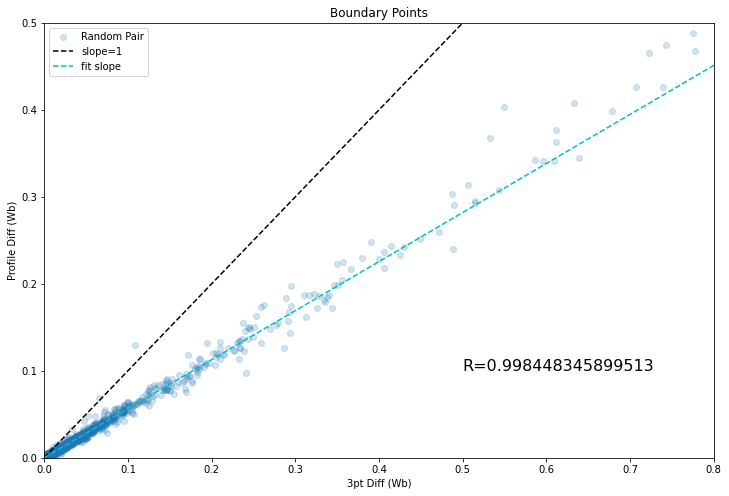

In [91]:
plot_flux_diffs(flux_per_amp_boundary)
plt.title('Boundary Points')
plt.ylim(0, .5)
plt.xlim(0, .8)
plt.legend()
# plt.savefig('boundary_flux_diff.jpg')

In [ ]:
plt.scatter(contour_points[:, 0], contour_points[:, 1])
plt.scatter(internal_xs, internal_ys)
plt.savefig('pts.jpg')

In [474]:
def plot_residuals(residuals):
    mean_residuals = np.mean(residuals, axis=1)
    plt.figure(figsize=(10, 6))
    plt.hist(mean_residuals, bins=50)
    plt.axvline(x=0.001203835037039374, label='3pt', c='k', linestyle='--') 
    plt.axvline(x=min(mean_residuals), label='Min', c='c', linestyle='--')
    plt.axvline(x=mean_residuals.mean(), label='Mean', c='y', linestyle='--')
    plt.xlabel('Residual Error to Fit (Wb)')
    plt.legend()

In [180]:
def plot_correlations(correlations):
    plt.figure(figsize=(10, 6))
    plt.hist(correlations, bins=50)
    plt.axvline(x=0.9976146943503987, label='3pt', c='k', linestyle='--')
    plt.axvline(x=max(correlations), label='Max', c='c', linestyle='--')
    plt.axvline(x=correlations.mean(), label='Mean', c='y', linestyle='--')
    plt.xlabel('Pearson Correlation Coef')
    plt.legend()

In [131]:
def plot_best_points(metric, points, num_to_plot, metric_name, title, label_function=None, ax=None):
    if ax is None:
        ax = plt.gca()

    if label_function is None:
        label_function = lambda x : x
        
    colors = list(mcolors.TABLEAU_COLORS.values())
    num_points = points.shape[1]
    sorted_point_indices = np.argsort(metric)
    ax.plot(contour_points[:, 0], contour_points[:, 1], c='k', zorder=1)

    plotting_index = 0
    i_pt_index = 0
    plotted_coords = []

    while i_pt_index < num_to_plot:
        point_index = sorted_point_indices[plotting_index]
        residual_at_index = metric[point_index]
        points_at_index = points[point_index]
        
        already_plotted = False
        for plotted_coord_set in plotted_coords:
            if np.all(plotted_coord_set == points_at_index):
                already_plotted = True
                break
        
        if already_plotted:
            plotting_index += 1
            continue

        plotted_coords.append(points_at_index)
        
        for i_point in range(num_points):
            if i_point == 0:
                ax.scatter(points_at_index[i_point][0], points_at_index[i_point][1], color=colors[i_pt_index], zorder=1/(1+i_pt_index), label=f'{metric_name} = {label_function(residual_at_index):.6f}')
            else:
                ax.scatter(points_at_index[i_point][0], points_at_index[i_point][1], color=colors[i_pt_index], zorder=1/(1+i_pt_index))

        plotting_index += 1
        i_pt_index += 1

    ax.scatter(three_pt_xs, three_pt_ys, label='Original 3pt', c='k')
    ax.legend()
    ax.set_title(title)

Determine # of points needed

In [381]:
means = []
mins = []
num_combinations = np.geomspace(1000, 30000, 15, dtype=int)
print(num_combinations)
for num_combo in num_combinations:
    metric, pts = numbad_try_random_point_selections(flux_per_amp_boundary, 3, num_combo)
    means.append(metric.mean())
    mins.append(metric.min())

[ 1000  1274  1625  2072  2642  3369  4295  5477  6983  8903 11352 14474
 18454 23529 30000]


In [15]:
metric_20k, pts = numbad_try_random_point_selections(flux_per_amp_boundary, 3, 10000, 20000)
metric_40k, pts = numbad_try_random_point_selections(flux_per_amp_boundary, 3, 10000, 40000)
metric_60k, pts = numbad_try_random_point_selections(flux_per_amp_boundary, 3, 10000, 60000)

In [22]:
metric_60k.shape

(10000, 60000)

In [39]:
coil_means = []

num_coil_combos = np.geomspace(1000, 60000, 50, dtype=int)
for num_coil_combo in num_coil_combos:
    idxs = random.sample(range(60000), num_coil_combo)
    coil_means.append(metric_60k[:, idxs].mean())

Text(0, 0.5, 'Mean Residual (Wb)')

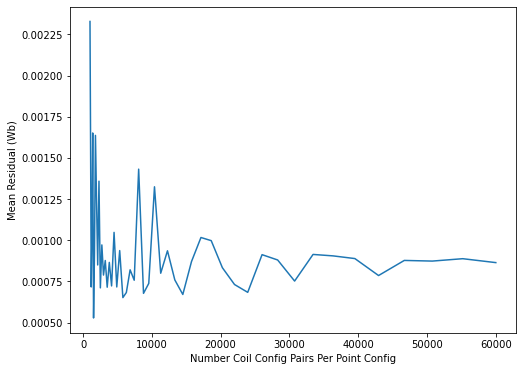

In [45]:
plt.figure(figsize=(8,6))
plt.plot(num_coil_combos, coil_means)
plt.xlabel('Number Coil Config Pairs Per Point Config')
plt.ylabel('Mean Residual (Wb)')

In [ ]:
metric, pts = numbad_try_random_point_selections(flux_per_amp_boundary, 3, 50000)

In [31]:
means = []
mins = []

num_combinations = np.geomspace(1000, 50000, 100, dtype=int)
for num_combo in num_combinations:
    np.random.shuffle(metric)
    vals = metric[:num_combo]
    means.append(vals.mean())
    mins.append(vals.min())

Text(0, 0.5, 'Mean Residual (Wb)')

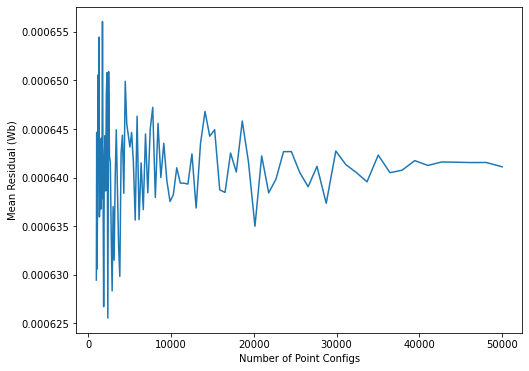

In [47]:
# ax = plt.gca()
# ax2 = ax.twinx()

plt.figure(figsize=(8,6))
plt.plot(num_combinations, means)
plt.xlabel('Number of Point Configs')
plt.ylabel('Mean Residual (Wb)')
# ax2.plot(num_combinations, mins, c='c')

In [441]:
metric = num_coil_config_sensitivity(flux_per_amp_boundary, 3, 30000, 30000) # is num combos x number coil configs 

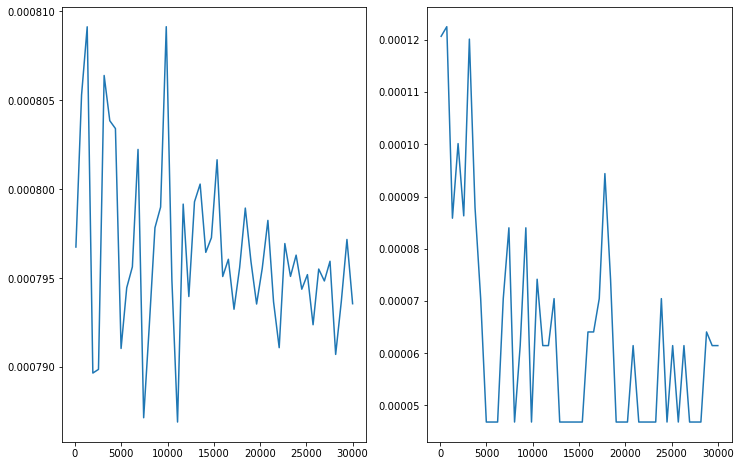

In [458]:
num_coil_configs_to_try = np.linspace(100, 30000, 50, dtype=int)

colors = list(mcolors.TABLEAU_COLORS.values())
means = []
mins = []
for num_coil_configs in num_coil_configs_to_try:
    random_idxs = np.random.choice(30000, num_coil_configs)
    random_residuals = metric[random_idxs]
    residual_means = np.mean(random_residuals, axis=1)
    means.append(residual_means.mean())
    mins.append(residual_means.min())

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].plot(num_coil_configs_to_try, means)
axs[1].plot(num_coil_configs_to_try, mins)


20000 is a good number

In [74]:
one_pt_residuals, one_pt_pts = numbad_try_random_point_selections(flux_per_amp_boundary, 1, 25000)

In [75]:
two_pt_residuals, two_pt_pts = numbad_try_random_point_selections(flux_per_amp_boundary, 2, 25000)

In [76]:

three_pt_residuals, three_pt_pts = numbad_try_random_point_selections(flux_per_amp_boundary, 3, 25000)


In [77]:
four_pt_residuals, four_pt_pts = numbad_try_random_point_selections(flux_per_amp_boundary, 4, 25000)


In [78]:
five_pt_residuals, five_pt_pts = numbad_try_random_point_selections(flux_per_amp_boundary, 5, 25000)


In [47]:
boundary_3pt_indices, higher_point_idx

([22, 1, 146], 44)

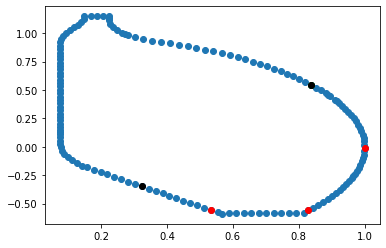

In [67]:
plt.scatter(contour_points[:, 0], contour_points[:, 1])
for idx in boundary_3pt_indices:
    plt.scatter(contour_points[idx, 0],  contour_points[idx, 1], c='r')
higher_point_idx = 44
plt.scatter(contour_points[higher_point_idx, 0],  contour_points[higher_point_idx, 1], c='g')

other_indices = [44, 136]
for idx in other_indices:
    plt.scatter(contour_points[idx, 0],  contour_points[idx, 1], c='k')

In [70]:
good_3_pt_residuals, good_3pt_pts = get_defined_pt_config_sensitivity(flux_per_amp_boundary, 100000, other_indices)

In [72]:
good_3pt_pts

array([[[ 0.83678004,  0.5475398 ],
        [ 0.3242005 , -0.3481936 ]]])

In [71]:
np.nanquantile(good_3_pt_residuals, axis=1, q=.95)

array([0.00029728])

In [42]:
og_3_pt_residuals, og_3pt_pts = get_defined_pt_config_sensitivity(flux_per_amp_boundary, 100000, boundary_3pt_indices)
# og_3_pt_plus_residuals, og_3pt_plus_pts = get_defined_pt_config_sensitivity(flux_per_amp_boundary, 25000, boundary_3pt_indices + [higher_point_idx])

In [60]:
og_3pt_pts

array([[[ 0.99995218, -0.00981273],
        [ 0.82813844, -0.56103363],
        [ 0.53332682, -0.55731991]]])

In [43]:
np.nanquantile(og_3_pt_residuals, axis=1, q=.95)

array([0.00225503])

In [21]:
two_pt_zmask_residuals, two_pt_zmask_pts = numbad_try_random_point_selections(flux_per_amp_boundary, 2, 20000)

In [27]:
two_pt_line_residuals, two_pt_line_pts = numbad_try_random_point_selections(flux_per_amp_boundary, 3, 20000)

In [80]:
import pickle
pickle.dump({'res': one_pt_residuals, 'pts': one_pt_pts}, open('one_pt_results.pickle', 'wb'))
pickle.dump({'res': two_pt_residuals, 'pts': two_pt_pts}, open('two_pt_results.pickle', 'wb'))
pickle.dump({'res': three_pt_residuals, 'pts': three_pt_pts}, open('three_pt_results.pickle', 'wb'))
pickle.dump({'res': four_pt_residuals, 'pts': four_pt_pts}, open('four_pt_results.pickle', 'wb'))
pickle.dump({'res': five_pt_residuals, 'pts': five_pt_pts}, open('five_pt_results.pickle', 'wb'))

In [56]:
np.mean(og_3_pt_residuals, axis=1), np.max(og_3_pt_residuals, axis=1), np.quantile(og_3_pt_residuals, q=.95, axis=1)

(array([0.00142755]), array([2.68535062]), array([0.00227573]))

In [83]:
nqs = np.nanquantile(two_pt_residuals, .95, axis=1)

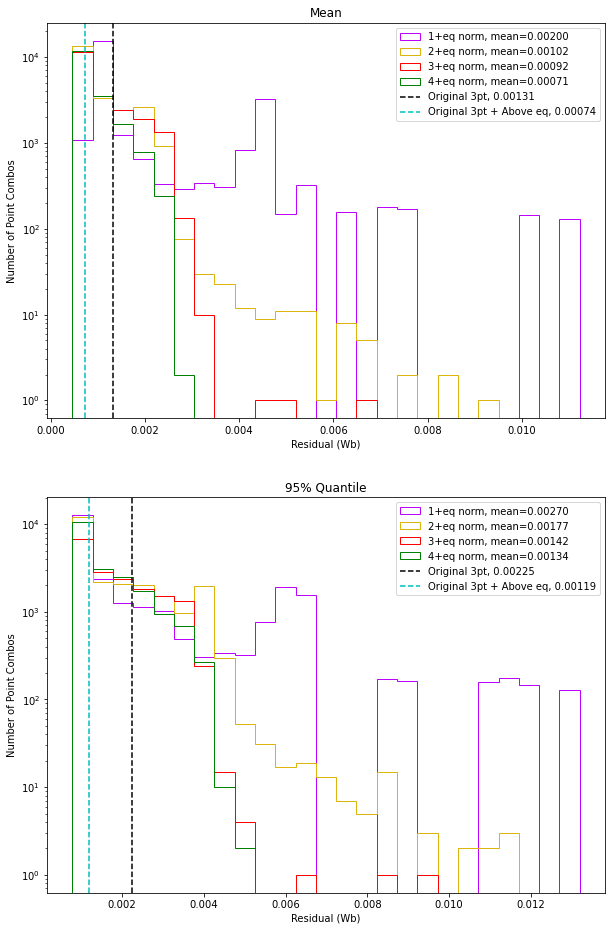

In [73]:
fig, axs = plt.subplots(2, 1, figsize=(10, 16))

data = (one_pt_residuals, two_pt_residuals, three_pt_residuals, four_pt_residuals)#, five_pt_residuals)
data_names = (1, 2, 3, 4)#, 5)
data_colors = ('xkcd:bright purple', 'xkcd:gold', 'r', 'g', 'b')
axis=1
for i_plot, (fxn, fxn_name) in enumerate(zip([np.mean, lambda arr, axis : np.quantile(arr, q=.95, axis=axis)], ['Mean', '95% Quantile'])):
    ax = axs[i_plot]
    for i_data, (metric, data_name, color) in enumerate(zip(data, data_names, data_colors)):
        vals = fxn(metric, axis=axis)
        if i_data == 0:
            ret = ax.hist(vals, histtype='step', color=color, bins=25, label=f"{data_name}+eq norm, mean={np.mean(vals):.5f}")
        else:
            ax.hist(vals, histtype='step', color=color, bins=ret[1], label=f"{data_name}+eq norm, mean={np.mean(vals):.5f}")
    og_3pt_val = fxn(og_3_pt_residuals, axis=axis)[0]
    ax.axvline(x=og_3pt_val, color='k', linestyle='--', label=f'Original 3pt, {og_3pt_val:.5f}' )
    og_3pt_plus_val = fxn(og_3_pt_plus_residuals, axis=axis)[0]
    ax.axvline(x=og_3pt_plus_val, color='c', linestyle='--', label=f'Original 3pt + Above eq, {og_3pt_plus_val:.5f}' )
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(fxn_name)
    ax.set_xlabel('Residual (Wb)')
    ax.set_ylabel('Number of Point Combos')

In [2]:
# load data
flux_per_amp_boundary = pickle.load(open('flux_per_amp_along_boundary.pickle', 'rb'))

one_pt_results = pickle.load(open('one_pt_results.pickle', 'rb'))
one_pt_residuals = one_pt_results['res']
one_pt_pts = one_pt_results['pts']

two_pt_results = pickle.load(open('two_pt_results.pickle', 'rb'))
two_pt_residuals = two_pt_results['res']
two_pt_pts = two_pt_results['pts']

three_pt_results = pickle.load(open('three_pt_results.pickle', 'rb'))
three_pt_residuals = three_pt_results['res']
three_pt_pts = three_pt_results['pts']

four_pt_results = pickle.load(open('four_pt_results.pickle', 'rb'))
four_pt_residuals = four_pt_results['res']
four_pt_pts = four_pt_results['pts']

five_pt_results = pickle.load(open('five_pt_results.pickle', 'rb'))
five_pt_residuals = five_pt_results['res']
five_pt_pts = five_pt_results['pts']

In [4]:
metric = [one_pt_residuals, two_pt_residuals, three_pt_residuals, four_pt_residuals, five_pt_residuals]


In [5]:
for residual_arr in metric:
    print(np.quantile(np.quantile(residual_arr, q=.95, axis=0), q=.95), np.quantile(np.quantile(residual_arr, q=.95, axis=1), q=.95))

0.006363240447361785 0.006207084719901369
0.004250398051093111 0.0036311404270412168
0.003842302254016081 0.0035686025544096373
0.0032873271544324044 0.0030902701098392787
0.0029829551549703523 0.0027941832214333725


In [21]:
print('axis0', np.mean(five_pt_residuals, axis=0).max(), np.mean(four_pt_residuals, axis=0).max(), np.mean(three_pt_residuals, axis=0).max())
print('axis1', np.mean(five_pt_residuals, axis=1).max(), np.mean(four_pt_residuals, axis=1).max(), np.mean(three_pt_residuals, axis=1).max())

axis0 0.3450480342980884 1.0908480596542018 0.5733372988530083
axis1 0.0027498989769148613 0.004274182183309517 0.0034331930757206647


The fact that we see the 4pt spike when taking the max of the quantile along axis=0 implies that there is a very bad coil combo. We also see this when taking the max of all residuals avgd over the point combinations

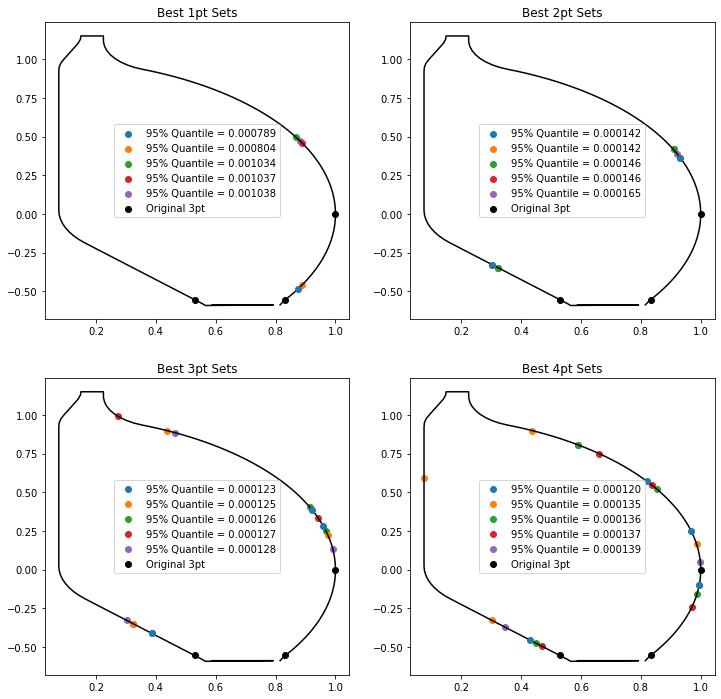

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plot_best_points(np.quantile(one_pt_residuals, q=.95, axis=1), one_pt_pts, 5, '95% Quantile', 'Best 1pt Sets', ax=axs[0, 0])
plot_best_points(np.quantile(two_pt_residuals, q=.95, axis=1), two_pt_pts, 5, '95% Quantile', 'Best 2pt Sets', ax=axs[0, 1])
plot_best_points(np.quantile(three_pt_residuals, q=.95, axis=1), three_pt_pts, 5, '95% Quantile', 'Best 3pt Sets', ax=axs[1, 0])
plot_best_points(np.quantile(four_pt_residuals, q=.95, axis=1), four_pt_pts, 5, '95% Quantile', 'Best 4pt Sets', ax=axs[1, 1])


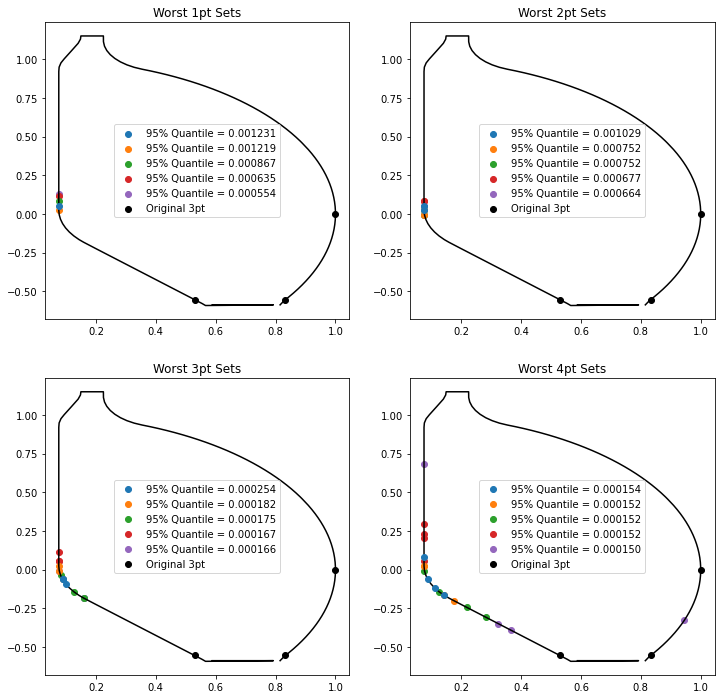

In [133]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
plot_best_points(np.quantile(-1*one_pt_residuals, q=.95, axis=1), one_pt_pts, 5, '95% Quantile', 'Worst 1pt Sets', ax=axs[0, 0], label_function=lambda x : -1 * x)
plot_best_points(np.quantile(-1*two_pt_residuals, q=.95, axis=1), two_pt_pts, 5, '95% Quantile', 'Worst 2pt Sets', ax=axs[0, 1], label_function=lambda x : -1 * x)
plot_best_points(np.quantile(-1*three_pt_residuals, q=.95, axis=1), three_pt_pts, 5, '95% Quantile', 'Worst 3pt Sets', ax=axs[1, 0], label_function=lambda x : -1 * x)
plot_best_points(np.quantile(-1*four_pt_residuals, q=.95, axis=1), four_pt_pts, 5, '95% Quantile', 'Worst 4pt Sets', ax=axs[1, 1], label_function=lambda x : -1 * x)

In [134]:
i_min = np.nanquantile(two_pt_residuals, q=.95, axis=1).argmin()
two_pt_pts[i_min]

array([[ 0.30328787, -0.32728096],
       [ 0.93245885,  0.36127715]])

TODO:
* look into how many points should be using
* look into parametrizing curve so not limited to quantized points 
* select best poins

Parameterize curve and see how looks there

In [135]:
three_pt_xs, three_pt_ys

([1, 0.833, 0.53], [0, -0.553, -0.553])

In [ ]:
contour_ls = [0]
for i_pt in range(contour_points.shape[0]):
    contour_ls.append(np.linalg.norm(contour_points[i_pt] - contour_points[i_pt-1]) + contour_ls[-1])

from scipy.interpolate import interp1d
contour_x_interp = interp1d(contour_ls, contour_points[:, 0])
contour_y_interp = interp1d(contour_ls, contour_points[:, 1])